# Using jax and optax for fast math & automatic differentiation

Today we'll be talking about jax and optax, some nifty libraries for the sort of stuff we deal with in signal processing. To begin, note that you'll have to get the following libraries:

* jaxlib (this is just a dependency)
* jax
* optax

These aren't natively available in windows. You can easily install them with pip or conda in linux, I'm not sure how exactly to do it in mac, but it should be doable. You can also use these libraries on google colab if you don't want to or can't install the libs. Colab environments have jaxlib and jax installed by default, so you can just go ahead and install optax and that'll be all.

You can read the docs here https://jax.readthedocs.io/en/latest/jax-101/index.html

In [1]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.0 MB/s 
     |████████████████████████████████| 72 kB 668 kB/s 


## jax
jax is a library made by some google people, but it's not officially a google product. It provides functionality that is (almost) identical to that of numpy, which is nice. This means we don't have to learn how to do the math in a different way than we're used to. There are a few differences, though:
* arrays are called "device arrays". This is because they can be stored in memory, GPU memory, or TPU memory.
* from the previous point, you might have guessed it already: your code can run on CPU or GPU without any changes.
* jax offers **just-in-time compilation (jit)**. This means that, when a block of code is executed, it will take **longer than usual** when it runs the first time. After that, calling the same block again can be 100x to 1000x faster.
* jax offers **automatic differentiation**, which makes dealing with gradients, jacobians, and hessians much easier. 
* jit and auto diff are **composable**. Under some conditions, one can arbitrarily compose jit compilation with differentiation of different kinds. This means you can have compiled higher order derivatives.

The cost to be paid is the following:
* device arrays are **static**. They don't like being modified, unless you replace them completely.
* moving a device array from one kind of storage to another is **costly**. For example, if we have a GPU device array and want to cast it back to a numpy array, the contents have to be copied from GPU memory to CPU memory, which is **slow**.
* to arbitrarily compose jit and differentiation, functions have to be **well-behaved**. This is close, but not really as strict as **functional programming**. Things like if-else branching, while loops, modifying global variables, printing are forbidden and will yield disgustingly long error tracebacks. Intermediate variables and replacement thereof is fine.
* the PRNG is **explicit**, meaning it does not keep track of its own state. **You** have to keep track of it!

You can read more about these things here https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

Let's look at some examples:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#first, some jax config
from jax.config import config
#this let's us use double precision numbers. the default is single precision.
config.update("jax_enable_x64", True)
import jax #jax itself, in case we need some random stuff from it
from jax import jit as jjit #this is a decorator for just-in-time compilation
import jax.numpy as jnp #jax's version of numpy



#lets print out some random vectors with numpy
print('with numpy:')
for i in range(3):
    print(np.random.normal(size=(2,)))

#in jax, we need to first generate keys that track the state
seed = 0 #prng seed
key = jax.random.PRNGKey(seed)
print('with jax:')
for i in range(3):
    print(jax.random.normal(key, shape=(2,)))

with numpy:
[-0.54487066  0.60026832]
[-1.12534171 -0.81696422]
[-0.40539631 -0.05918759]
with jax:
[ 1.81608667 -0.75488484]
[ 1.81608667 -0.75488484]
[ 1.81608667 -0.75488484]


As you can see, the PRNG is not updated automatically. We have to explicitly ask jax to generate new keys from the old one. We won't go into details, just know that the commong approach is to generate two keys from an old one. One of the keys is used for whatever we need it (e.g. sampling a random distribution). The other key is used to generate new keys in the future.

In [3]:
seed = 0 #prng seed
key = jax.random.PRNGKey(seed)
print('attempt #2 with jax:')
for i in range(3):
    key, subkey = jax.random.split(key) #generate 2 new keys
    print(jax.random.normal(subkey, shape=(2,))) #use one of them in our normal distribution

attempt #2 with jax:
[ 1.13787844 -0.14331426]
[-0.06607245  0.79278191]
[-2.20514421 -1.41387334]


There we go! Keep in mind the results will always be the same if you do the splitting and generate the seed in exactly the same way. One could instead generate the seed with numpy's stateful PRNG to spice things up. If you prefer, you can simply generate random quantities in numpy and cast them to jax device arrays later. Just keep in mind this might be slower.

---

## automatic differentiation

At any rate, that was a quick intro to what is arguably the weirdest part to deal with. The rest should be a lot more familiar. Let's set up a linear model and play around with it.

In [4]:
key, sk1, sk2 = jax.random.split(key, num = 3) #this time we'll make 3 random key. 2 for us to use, 1 for later.
A = jax.random.normal(sk1, shape=(10,10)) #we make a random matrix...
x = jax.random.normal(sk2, shape=(10,)) #... and a random vector...
y = A.dot(x) #... and get their product as usual!
print(y) #because why not?

[ 1.06660449  0.29026105  4.14155173 -0.11927005 -3.25627238  3.31087758
 -0.33040366 -4.40455618 -2.4080758  -3.53746502]


So far, so good. Now, what if we want to do some gradient descent to estimate $\boldsymbol{x}$ given $\boldsymbol{A}$ and $\boldsymbol{y}$? We'd need the gradient, for starters.

In [5]:
x_hat = jnp.zeros((10)) #same as with regular numpy

#now, let's set up a cost function. least squares comes to mind.
@jjit #note the decorator!
def ls(x, A, y):
    return jnp.sum((A.dot(x) - y)**2)

#we already know what the gradient should be. how about we automate it, though?
#grad takes in a function, and then argnums specifies the index of the parameters that the
#gradient will be computed with respect to. here, we wanna differentiate wrt x. read the docs
#for more info! https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html 
ls_grad = jjit(jax.grad(ls, argnums = 0)) #and let's jit it, too

#let's compare the analytic gradient vs jax's result, shall we?
key, subkey = jax.random.split(key)
x_hat = jax.random.normal(subkey, shape=(10,))

grad_reference = 2*A.T.dot(A.dot(x_hat) - y) #don't forget the 2 in front!
grad_jax = ls_grad(x_hat, A, y) #note!! the gradient takes in the SAME parameters as the original function!
print(grad_reference - grad_jax)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Pretty cool, huh? Now let's set this up for the case in which we have complex quantities. This would make the cost function non holomorphic, and the complex derivatives won't exist. However, we instead use Wirtinger (or $\mathbb{CR}-$) calculus. This considers complex parameters as two real parameters each, and takes only real derivatives. You can brush up your Wirtinger calc here https://arxiv.org/pdf/0906.4835.pdf; we'll just go ahead and use the result that tells us that, for real-valued functions of complex parameters, we can compute the gradient by differentiating w.r.t. the complex conjugate of the complex parameters. There's a sneaky factor of 2 here and there that we'll have to account for, but we already did that above. Shouldn't be much of a problem at all!

In [6]:
key, sk1, sk2, sk3, sk4 = jax.random.split(key, num = 5)
A = jax.random.normal(sk1, shape=(10,10)) + 1j*jax.random.normal(sk2, shape=(10,10))
x = jax.random.normal(sk3, shape=(10,)) + 1j*jax.random.normal(sk4, shape=(10,))
y = A.dot(x) #... and get their product as usual!

@jjit #note the decorator!
def ls(x, A, y):
    temp = A.dot(x) - y #see? no problem with making a few imperative statements here and there
    #we could've also just used the old expression and added in a jnp.real() & jnp.imag()
    return jnp.real(temp.conjugate().T.dot(temp))

ls_grad = jjit(jax.grad(ls, argnums = 0)) #same as before

#and we again compare the two
key, subkey = jax.random.split(key)
x_hat = jax.random.normal(subkey, shape=(10,))

grad_reference = A.conjugate().T.dot(A.dot(x_hat) - y) #we normally don't put the factor 2 here...
grad_jax = ls_grad(x_hat, A, y)/2 #aha, but now it pops up here. this depends on the author, but some
#people like putting a factor 2 in front of the Wirtinger gradient, since the dimensions of the
#matrices double when splitting into real and imag parts
print(jnp.abs(grad_reference - grad_jax))

[ 8.18734618  4.87918144 12.14883054 16.22418151 20.35057549  7.69868882
  5.56329827  6.12455628 17.06479612 26.7119277 ]


So, what went wrong here? Let's take a closer look:

In [7]:
print(grad_reference - grad_jax)

[0. -8.18734618j 0. -4.87918144j 0.+12.14883054j 0.+16.22418151j
 0.-20.35057549j 0. -7.69868882j 0. +5.56329827j 0. -6.12455628j
 0.-17.06479612j 0.+26.7119277j ]


Aha! The real parts are correct, but the jax.grad() function expects a function $f:\mathbb{R} \to \mathbb{R}$ or $f:\mathbb{C} \to \mathbb{C}$ that is holomorphic. Our function was neither: we had $f:\mathbb{C} \to \mathbb{R}$, which is not holomorphic in general. We can get around this by using jax.jacfwd(), jax.vjp(), or separating real and imaginary parts (you can read it out here https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html, but honestly I find the authors' notation to be... not the clearest). Let's take another shot at it.

In [8]:
x_hat = x_hat + 0j
@jjit #note the decorator!
def ls(xr, xi, A, y): #split real and imaginary parts of the input
    temp = A.dot(xr + 1j*xi) - y #see? no problem with making a few imperative statements here and there
    #we could've also just used the old expression and added in a jnp.real() & jnp.imag()
    return jnp.real(temp.conjugate().T.dot(temp)) #we don't need the real here anymore

ls_grad = jjit(jax.grad(ls, argnums = (0,1))) #the parameters work much in the same way as with grad

grad_reference = A.conjugate().T.dot(A.dot(x_hat) - y) #we normally don't put the factor 2 here...
grad_jax = ls_grad(jnp.real(x_hat), jnp.imag(x_hat), A, y) 
print(f'the gradient is of type {type(grad_jax)} and length {len(grad_jax)}')
print(f'each element of the gradient is of type {type(grad_jax[0])} and shape {grad_jax[0].shape}')


the gradient is of type <class 'tuple'> and length 2
each element of the gradient is of type <class 'jaxlib.xla_extension.DeviceArray'> and shape (10,)


So, when we specify a tuple in argnums, we also get a tuple back. Good to know! Furthermore, each element of the tuple has the dimension you'd expect of the gradient. All right. Double the number of parameters passed to the function we're differentiating, but they're real instead of complex, so it should take up the same amount of memory.

In [9]:
print(grad_reference - (grad_jax[0] + 1j*grad_jax[1])/2) #aha, but now it pops up here. 
#this depends on the author, but some people like putting a factor 2 in front of the Wirtinger gradient,
#since the dimensions of the matrices double when splitting into real and imag parts

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


Sweet! We got this working right. Just keep in mind that if a function is vector-valued, you'll have to use some form of jacobian function instead of taking gradients. They work the same way: a tuple of parameter indices has to be specified for differentiation, and the output will be a tuple in that same order. One can also call grad(grad(...)) or jacfwd(jacfwd(...)), you get the idea. 

All right, so what else can we do with this?

---

## efficient vectorization/batching/parallelization

Turns out jax can efficiently "vectorize" function inputs and outputs. By this, I mean that it can add extra axes to the inputs and then evaluate the function in parallel over those axes (independently of each other). In machine learning, this would be similar to processing a batch of data together (if you decide to add/average/etc. the gradients). This is done with jax.vmap(). Additionally, there's jax.pmap(), which we won't go over. However, this latter one allows the function to be parallelized over hardware, e.g. different processors or GPUs. You can think of this latter one as using dask or multiprocessing. 

Let's go back to vmap and play around for a bit, though. For starters, let's take our least squares function and make it so that we can apply it to several values of $\boldsymbol{x}$ and $\boldsymbol{y}$ simultaneously.

In [10]:
#let's see how jax.vmap() works, then
#with in_axes, we provide a tuple whose elements correspond to the input parameters of the function.
#the parameters specify which axis of the corresponding parameter to vectorize over. here, we've told
#jax that the axis 1 (columns) will represent different values of the same variable (i.e. each column
#of the input is a new parameter x or y). furthermore, we've specified we want to do this for xr, xi, and y,
#with no vectorization for the matrix A. out_axes works much in the same way. the original function returns
#a scalar, so i've set out_axes to 0 to return a column vector. each entry in the column vector will correspond
#to a column of the vectorized parameters.
batch_ls = jjit(jax.vmap(ls, in_axes = (1, 1, None, 1), out_axes = 0))

#let's do 5 evaluations of ls now
num_batches = 5
key, sk1, sk2, sk3, sk4, sk5, sk6 = jax.random.split(key, num = 7) #yeah, yeah... poor style
A = jax.random.normal(sk1, shape=(10,10)) + 1j*jax.random.normal(sk2, shape=(10,10))
x_batch = jax.random.normal(sk3, shape=(10,num_batches)) + 1j*jax.random.normal(sk4, shape=(10,num_batches))
y_batch = A.dot(x_batch) #... and get their product as usual!
#these ones are going to be used instead of the true x values to get nonzero errors
x_hat_batch = jax.random.normal(sk5, shape=(10,num_batches)) + 1j*jax.random.normal(sk6, shape=(10,num_batches))

#here are all the outputs
ls_outputs = batch_ls(jnp.real(x_hat_batch), jnp.imag(x_hat_batch), A, y_batch)

#and for comparison, we'll also compute the first one using the original ls function
ls0 = ls(jnp.real(x_hat_batch[:,0]), jnp.imag(x_hat_batch[:,0]), A, y_batch[:,0])

print(ls_outputs)
print(ls0)


[ 924.90071277  503.20575404  882.42142103 1335.29396885  758.99111762]
924.9007127664681


Awesomeness. In some scenarios, this can save you the heartbreak of dealing with block-diagonal matrices and/or loops, so it can replace einsum in some scenarios.

---

## batch gradient descent with optax

All right, so now let's bring all of this together to do something cool. We can set up some batch gradient descent by using jax and optax, which should be useful for many of us. 

Let's set up a linear model for a polynomial coefficient estimation task (fun times with Vandermode matrices). Since we know the gradient and have a fixed model, we could just do everything analytically if we pick a fixed step size based on the singular values of the model matrix. That's boring stuff. **Let's use a data-driven approach to optimally learn the descent step size instead.**

In [11]:
#let's not make this unnecessarily painful, let's stick to low degree polys, e.g. quadratics. this means
#there are 3 coefficients, and observations of the form y_i = ax_i^2 + bx_i + c can be vectorized so that
#the coefficients c and y are related through a vandermonde matrix that depends on x. then, we can set up 
#a least squares loss as ||c - c_hat||_2^2.

@jjit
def loss(c, c_hat): #this tells us how good our estimate of c is
    return jnp.sum((c - c_hat)**2)

Because of the built-in Vandermonde function's column order, this means the parameters in c must be arranged in decreasing order of the power of x they will multiply. Just something to keep in mind. Now, we already know what the gradient looks like for this. How about we set up a function that takes care of it? We'll pick a fixed number of iterations and estimate the step size. **This is equivalent to algorithm unfolding/unrolling, which is pretty hyped up in the ML community at the moment. Coolbeans.** This is a super simplified example, though, where we're just learning a single hyperparameter.


In [12]:
#here's just a quick example of what vander does. we'll use it later
x = jnp.array([2,3,4])
print(jnp.vander(x,N=3))
print('note that the powers increase toward the left')

@jjit
def estimate(A, y, c0, mus): #this one estimates c
    #NOTE! another thing here. we could perfectly well do something like
    '''
    for mu in mus: #take a handful of iterations
        c0 = c0 - mu*A.T.dot(A.dot(c0) - y) #do a gradient descent step
    '''
    #HOWEVER! this is takes a long time for jax to compile. 
    
    #we can and SHOULD instead use jax loops:
    def body(n, parameters):
      A, y, c0, mus = parameters #unpack parameters
      c0 = c0 - mus[n]*A.T.dot(A.dot(c0) - y) #compute a descent step with mu[n]
      return (A, y, c0, mus)

    #this function takes in a range for n (the first two params),
    #a body function with parameters n and "val", and returns a updated "val",
    #and an initial value for the variable "val"
    _, _, c0, mus = jax.lax.fori_loop(0, len(mus), body, (A, y, c0 ,mus))
    
    return c0

[[ 4  2  1]
 [ 9  3  1]
 [16  4  1]]
note that the powers increase toward the left


Now comes the cool part. We can plug in our estimator into the loss function, and then have jax auto diff w.r.t. the step size without batting an eyelash.

In [13]:
@jjit
def target(A, y, c, c0, mu):
    c0 = estimate(A, y, c0, mu)
    return loss(c, c0)

grad = jjit(jax.grad(target, argnums = 4)) #differentiate w.r.t. step sizes

You have to admit, that's pretty nice and succinct. It's also a full neural network with as many layers as the length of the vector of step sizes. Let's take it a step further and turn this into a batch gradient.

In [14]:
batch_grad = jjit(jax.vmap(grad, in_axes=(None,1,1,None,None), out_axes=1)) #vectorize over x, y, and c, and put the
#per example gradients as columns in the output

Let's try out the gradient function and see what the output looks like.

In [15]:
mu = jnp.ones(50)*1e-7 #completely made up value for the step size

#let's generate some data
key, sk1, sk2 = jax.random.split(key, num = 3)
nb = 5 #number of batches
x = jnp.linspace(-10,10,20)
A = jnp.vander(x, N = 3)
c_batches = jax.random.normal(sk2, shape=(3, nb)) #3 coefficients for each of the 5 batches
y_batches = jnp.vander(x, N = 3).dot(c_batches) #20 x 5

per_example_grad = batch_grad(A, y_batches, c_batches, jnp.zeros((3)), mu)
print((per_example_grad.shape))


(50, 5)


Excellent, now all the pieces are in place. We have a cost function, we know how to compute its gradient w.r.t. the parameters of interest, and we can even do so for a batch of several examples at the same time. Time for optax to make its entrace. Optax is a library that originally was a part of jax, but eventually it became a thing of its own under the DeepMind team. The basic functionality is pretty simple:
* choose an optimizer from the ones optax offers (you can also write your own, but we won't)
* initialize it with the initial guess of the parameters. this sets the state of the optimizer
* use the optimizer's update(gradient, state) function to update its state and compute an update to the parameters based on the gradient (recall that many optimization techniques take the gradient as a starting point, and then go on to compute momentum, estimate the Hessian, etc.)
* apply the update to the parameters
and that's about it. In code, this takes one line per step. It also allows arbitrary nesting of parameter structures, which is the reason the 4th step exists. It can save you the pain of figuring out how exactly to apply the update to a list of dictionaries of pytrees of matrices, for example.

Let's see how this works in code:

In [16]:
import optax

#recall we already made an initial guess for the parameters, we called it mu
mu = jnp.zeros(800)

#let's go with the adam optimizer, because why not? the learning rate i chose here is also arbitrary.
#it could also be optimized by wrapping all of this stuff into yet another function, and optimizing it
#with optax! but we won't :P
learning_rate = 1e-6
optimizer = optax.rmsprop(learning_rate) #choose an optimizer
opt_state = optimizer.init(mu) #initialize the optimizer state by giving it the initial guess

#now, we set up a training scenario. let's optimize the descent step sizes a large number
#of examples, which we will split into smaller batches
total = 1000000
batch_size = 1000
num_batches = int(total/batch_size)
x_len = 20 #let's say we have 20 samples for each polynomial
x = jnp.linspace(-5, 5, x_len)
A = jnp.vander(x, N = 3)
for i in range(num_batches):
    if i%50 == 0:
        print(f'currently in batch {i+1} from {num_batches}...')
    #let's generate some data
    key, sk1, sk2 = jax.random.split(key, num = 3)
    c_batches = jax.random.uniform(sk2, shape=(3, batch_size),
                minval = -100, maxval = 100) #3 x batch_size
    y_batches = A.dot(c_batches) #x_len x batch_size
    gradients = batch_grad(A, y_batches, c_batches, jnp.zeros((3)), mu)
    
    #let's go ahead and average the gradients. we could also just add them up, or otherwise produce
    #a weighted sum, depending on how we want to look at the cost function.
    gradients = jnp.sum(gradients, axis=1)/batch_size #average over the columns
    
    #now, let's use the gradients to produce a parameter update and ALSO update the optimizer state
    updates, opt_state = optimizer.update(gradients, opt_state)
    
    #and finally, apply the update to our parameters
    mu = optax.apply_updates(mu, updates)
    mu = mu*(mu > 0) #projected gradient
    #print(gradients)

currently in batch 1 from 1000...
currently in batch 51 from 1000...
currently in batch 101 from 1000...
currently in batch 151 from 1000...
currently in batch 201 from 1000...
currently in batch 251 from 1000...
currently in batch 301 from 1000...
currently in batch 351 from 1000...
currently in batch 401 from 1000...
currently in batch 451 from 1000...
currently in batch 501 from 1000...
currently in batch 551 from 1000...
currently in batch 601 from 1000...
currently in batch 651 from 1000...
currently in batch 701 from 1000...
currently in batch 751 from 1000...
currently in batch 801 from 1000...
currently in batch 851 from 1000...
currently in batch 901 from 1000...
currently in batch 951 from 1000...


Let's check out what we got!

the largest possible step size should be 0.0006546662390544673
we get 0.0006511752533547151 with our overkill estimation setup
the original coefficients were [-42.0778063   12.80168182 -20.70545477]
our estimator found[-42.04822179  12.80168182 -21.30791232]


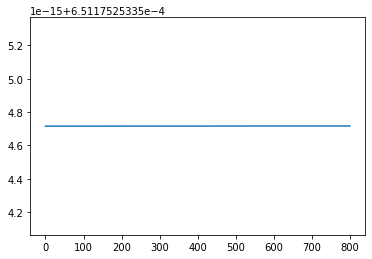

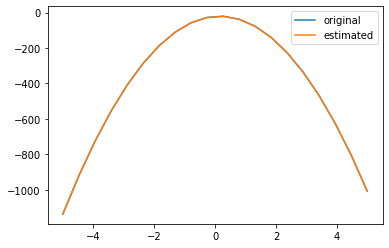

In [18]:
plt.figure()
plt.plot(mu)

#and now, let's test the step sizes on a polynomial
key, sk1 = jax.random.split(key)
c  = jax.random.uniform(sk1, shape=(3,), minval = -100, maxval = 100)
y = A.dot(c)

eigs,_ = jnp.linalg.eigh(A.T.dot(A))
print(f'the largest possible step size should be {2/eigs[-1]}')
print(f'we get {mu[0]} with our overkill estimation setup')

key, sk1 = jax.random.split(key)
c_hat = jax.random.uniform(sk1, shape=(3,), minval = -100, maxval = 100)
c_hat = estimate(A, y, c_hat, mu)

print(f'the original coefficients were {c}')
print(f'our estimator found{c_hat}')
plt.figure()
plt.plot(x,y)
plt.plot(x, A.dot(c_hat))
plt.legend(('original', 'estimated'))

And there we go! Super unnecessary in this example, but the idea was to get you familiar and comfortable with composition of jax functions.

I'd again like to highlight that this last example could be seen either as algorithm unfolding, or alternatively as hyper parameter optimization.

As a final word of caution, recall that we nested several layers of jit, grad, and functions of our own making. You WILL find bugs, and the error stacks WILL be disgusting. Be patient :P